# Code

In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import np_utils

In [2]:
filename = '../Data/BERT2560/Combined/reshape_bb_2560.csv'

In [3]:
data = pd.read_csv(filename)

In [4]:
filename = filename[:filename.index('.')]

In [5]:
# data = data[:2000]
label = data['label']
features = data.drop(['uid', 'label'], axis=1)

In [6]:
del data

In [8]:
#features = features.to_numpy()
features = features.reshape(39259, 5, 768)

In [9]:
X, a, y, b = train_test_split(features, label, random_state=42, stratify=label, test_size=0.3)
print(X.shape, y.shape, a.shape, b.shape)

Xv, Xt, yv, yt = train_test_split(a, b, random_state=42, stratify=b, test_size=0.4)
print(Xv.shape, Xt.shape, yv.shape, yt.shape)

# Xv = X[-6000:]
# X = X[:-6000]

(27481, 5, 768) (27481,) (11778, 5, 768) (11778,)
(7066, 5, 768) (4712, 5, 768) (7066,) (4712,)


In [10]:
# defining the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(features.shape[1], features.shape[2]), return_sequences=True, activation='relu')) #bidirectional lstm
model.add(Dropout(0.25)) #do for both bid and normal lstm 
model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(20))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

In [11]:
model.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [12]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('best_model_lstm_bb' + filename + '_.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [14]:
history = model.fit(X, y, validation_data=(Xv, yv), epochs=1000, batch_size=16, callbacks=[es, mc])

Epoch 1/1000
1718/1718 [==============================] - ETA: 0s - loss: 0.6836 - accuracy: 0.5634
Epoch 1: val_accuracy improved from -inf to 0.57147, saving model to best_model_lstm_bb_.h5
1718/1718 [==============================] - 32s 18ms/step - loss: 0.6836 - accuracy: 0.5634 - val_loss: 0.6870 - val_accuracy: 0.5715
Epoch 2/1000
1716/1718 [============================>.] - ETA: 0s - loss: 0.6724 - accuracy: 0.5787
Epoch 2: val_accuracy did not improve from 0.57147
1718/1718 [==============================] - 27s 16ms/step - loss: 0.6724 - accuracy: 0.5788 - val_loss: 0.6752 - val_accuracy: 0.5654
Epoch 3/1000
1718/1718 [==============================] - ETA: 0s - loss: 0.6655 - accuracy: 0.5906
Epoch 3: val_accuracy improved from 0.57147 to 0.59595, saving model to best_model_lstm_bb_.h5
1718/1718 [==============================] - 28s 16ms/step - loss: 0.6655 - accuracy: 0.5906 - val_loss: 0.6584 - val_accuracy: 0.5960
Epoch 4/1000
1716/1718 [============================>.] -

Epoch 28/1000
1718/1718 [==============================] - ETA: 0s - loss: 0.5017 - accuracy: 0.7475
Epoch 28: val_accuracy improved from 0.65341 to 0.65780, saving model to best_model_lstm_bb_.h5
1718/1718 [==============================] - 39s 23ms/step - loss: 0.5017 - accuracy: 0.7475 - val_loss: 0.6597 - val_accuracy: 0.6578
Epoch 29/1000
1718/1718 [==============================] - ETA: 0s - loss: 0.4971 - accuracy: 0.7528
Epoch 29: val_accuracy did not improve from 0.65780
1718/1718 [==============================] - 37s 21ms/step - loss: 0.4971 - accuracy: 0.7528 - val_loss: 0.6721 - val_accuracy: 0.6560
Epoch 30/1000
1718/1718 [==============================] - ETA: 0s - loss: 0.4906 - accuracy: 0.7576
Epoch 30: val_accuracy did not improve from 0.65780
1718/1718 [==============================] - 36s 21ms/step - loss: 0.4906 - accuracy: 0.7576 - val_loss: 0.6893 - val_accuracy: 0.6551
Epoch 31/1000
1717/1718 [============================>.] - ETA: 0s - loss: 0.4820 - accuracy

In [15]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [16]:
saved_model = load_model('best_model_lstm_bb' + filename + '_.h5')
# evaluate the model
_, train_acc = saved_model.evaluate(X, y, verbose=0)
_, test_acc = saved_model.evaluate(Xt, yt, verbose=0)

print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.769, Test: 0.657


In [17]:
lst = [train_acc, test_acc]
df = pd.DataFrame(lst, index =['train_acc', 'test_acc'])
df.to_csv(filename +'bb_lstm_results.csv')

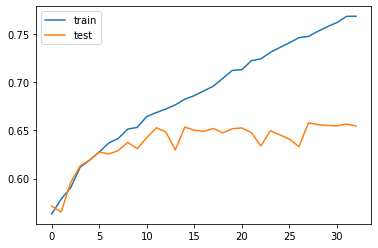

In [18]:
# plot history
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.savefig(filename + 'bb_lstm_acc.png', bbox_inches='tight')
pyplot.show()


In [19]:
from matplotlib import pyplot as plt

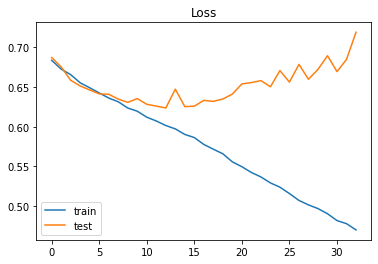

In [20]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
pyplot.savefig(filename + 'bb_lstm_loss.png', bbox_inches='tight')
plt.show();

In [22]:
from sklearn.metrics import confusion_matrix
saved_model = load_model('best_model_lstm_bb_' +'.h5')
yp = (saved_model.predict(X) > 0.5).astype('int32') 
matrix = confusion_matrix(y,yp, labels=[1,0])
cm = pd.DataFrame(matrix, index=['1','0'],columns=['1','0'])
from sklearn.metrics import accuracy_score
print("Test Accuracy Score: %.3f" %(accuracy_score(y,yp)))

from sklearn.metrics import recall_score
print("Test Recall Score: %.3f" %(recall_score(y,yp)))

from sklearn.metrics import precision_score
print("Test Precision Score: %.3f" %(precision_score(y,yp)))

from sklearn.metrics import f1_score
print("Test F1 Score: %.3f" %(f1_score(y,yp)))
yp = (saved_model.predict(Xt) > 0.5).astype('int32') 
matrix = confusion_matrix(yt,yp, labels=[1,0])
cm = pd.DataFrame(matrix, index=['1','0'],columns=['1','0'])

print("Test Accuracy Score: %.3f" %(accuracy_score(yt,yp)))


print("Test Recall Score: %.3f" %(recall_score(yt,yp)))


print("Test Precision Score: %.3f" %(precision_score(yt,yp)))


print("Test F1 Score: %.3f" %(f1_score(yt,yp)))

Test Accuracy Score: 0.769
Test Recall Score: 0.638
Test Precision Score: 0.787
Test F1 Score: 0.705
Test Accuracy Score: 0.657
Test Recall Score: 0.479
Test Precision Score: 0.636
Test F1 Score: 0.546
